##Pothole Detection

##Installing and Importing Necessary Libraries

In [ ]:
!pip install tensorflow-gpu==2.0.0

In [ ]:
!pip install keras-tuner

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, cohen_kappa_score, classification_report, roc_curve, confusion_matrix
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from imutils import paths
from google.colab import drive
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tqdm import tqdm_notebook as tqdm
import os
import cv2
from warnings import filterwarnings

In [4]:
filterwarnings("ignore")

In [5]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/9. Potholes Detection CNN using Optimization")

## Data extraction from images

In [7]:
imagepaths = sorted(list(paths.list_images("dataset")))

In [8]:
data = []
label = []
with tqdm(total=len(imagepaths)) as pbar:
    for i in imagepaths:
        try:
            image = cv2.imread(i)
            image = cv2.resize(image, (28,28))
        except:
            continue
        data.append(img_to_array(image))
        label.append(i.split(sep="/")[1])
        pbar.update(1)    


  0%|          | 0/29 [00:00<?, ?it/s]

In [9]:
data = np.array(data, dtype= "float")
flabels = np.array([1 if i=="potholes" else 0 for i in label])

##Splitting the data

In [10]:
x_train, x_test, y_train, y_test = train_test_split(data, flabels, test_size = 0.2, random_state = 10, stratify = flabels)

##Building the model

In [11]:
def build_model(hp):
    model = Sequential([
                        Conv2D(filters = hp.Int("conv_1_filter", min_value = 32, max_value = 128, step = 16),
                               kernel_size = hp.Choice("conv_1_kernel", values = [3,5]),
                               activation = "relu"),
                        MaxPooling2D(pool_size = (2,2), strides= (1,1)),
                        Conv2D(filters = hp.Int("conv_2_filter", min_value = 32, max_value = 128, step = 16),
                               kernel_size = hp.Choice("conv_2_kernel", values= [3,5]),
                               activation = "relu"),
                        MaxPooling2D(pool_size = (2,2), strides= (1,1)),
                        Flatten(),
                        Dense(units = hp.Int("Dense_1", min_value = 128, max_value = 512, step = 64), activation = "relu"),
                        Dense(units = hp.Int("Dense_2", min_value = 128, max_value = 512, step = 64), activation = "relu"),
                        Dense(units = hp.Int("Dense_3", min_value = 128, max_value = 512, step = 64), activation = "relu"),
                        Dense(1, activation = "sigmoid")                   

    ])

    model.compile(optimizer = Adam(),
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])

    return model

##Model Optimization

In [12]:
tuner_search = RandomSearch(build_model, max_trials= 25, objective= "accuracy", directory = "ouput_models", project_name = "Potholes Detection")
tuner_search.search(x_train, y_train, epochs = 50, validation_split = 0.2)

Trial 25 Complete [00h 00m 15s]
accuracy: 1.0

Best accuracy So Far: 1.0
Total elapsed time: 00h 08m 20s
INFO:tensorflow:Oracle triggered exit


##Building the best model

In [33]:
best_model = tuner_search.get_best_models()[0]

In [34]:
best_model.build(input_shape = (None,28,28,3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  9912640   
_________________________________________________________________
dense_1 (Dense)              multiple                  6

In [35]:
M1 = best_model.fit(data, flabels, validation_split = 0.2, epochs = 50)

Train on 23 samples, validate on 6 samples
Epoch 1/50
23/23 [==============================] - 1s 47ms/sample - loss: 0.3598 - accuracy: 0.8696 - val_loss: 0.2475 - val_accuracy: 0.8333
Epoch 2/50
23/23 [==============================] - 0s 14ms/sample - loss: 0.2192 - accuracy: 0.9130 - val_loss: 0.2316 - val_accuracy: 0.8333
Epoch 3/50
23/23 [==============================] - 0s 14ms/sample - loss: 0.1804 - accuracy: 1.0000 - val_loss: 0.2524 - val_accuracy: 0.8333
Epoch 4/50
23/23 [==============================] - 0s 15ms/sample - loss: 0.1364 - accuracy: 0.9565 - val_loss: 0.3213 - val_accuracy: 0.8333
Epoch 5/50
23/23 [==============================] - 0s 14ms/sample - loss: 0.0133 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 1.0000
Epoch 6/50
23/23 [==============================] - 0s 15ms/sample - loss: 0.0581 - accuracy: 0.9565 - val_loss: 0.6085 - val_accuracy: 0.8333
Epoch 7/50
23/23 [==============================] - 0s 15ms/sample - loss: 0.0139 - accuracy: 1.000

##Model Evaluation

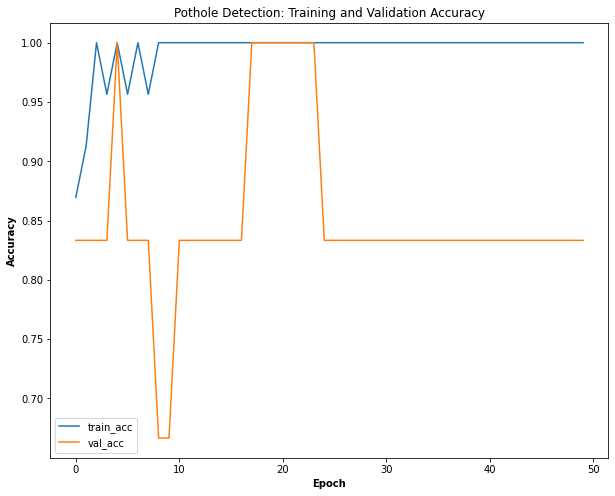

In [37]:
Epochs = 50
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, Epochs), M1.history["val_accuracy"], label="val_acc")
plt.title("Pothole Detection: Training and Validation Accuracy")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

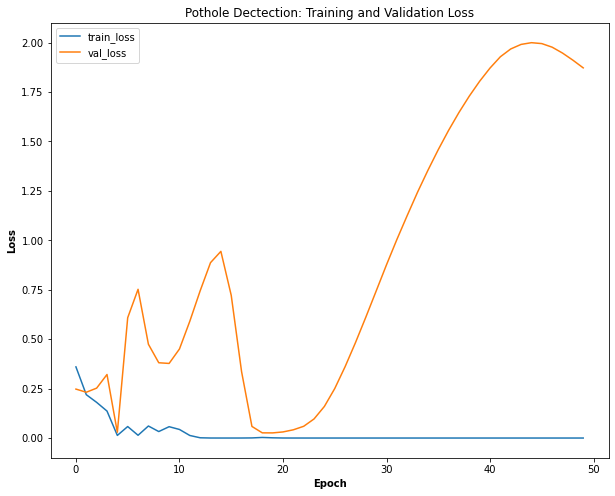

In [38]:
plt.figure(figsize = [10,8])
plt.plot(np.arange(0, Epochs), M1.history["loss"], label="train_loss")
plt.plot(np.arange(0, Epochs), M1.history["val_loss"], label="val_loss")
plt.title("Pothole Dectection: Training and Validation Loss")
plt.xlabel("Epoch", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

In [39]:
def plot_roc(y_pred_prob):
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    fig = plt.figure(figsize= (20,15))
    plt.plot(fpr,tpr)
    plt.plot([0,1],"r--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.text(x = 0.02, y = 0.85, s = ("AUC Score: ", roc_auc_score(y_test, y_pred_prob)))
    plt.title('ROC Curve for Vehicle Detection', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
    plt.grid(True)

In [40]:
def model_evaluation(y_test, y_pred):
    print("Cohen Kappa Score:", cohen_kappa_score(y_test, y_pred), "\n")
    print("Classification Report--> \n", classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm)
    sns.heatmap(cm, annot =True, fmt ="d")
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")

In [41]:
y_pred_prob = best_model.predict(x_test)

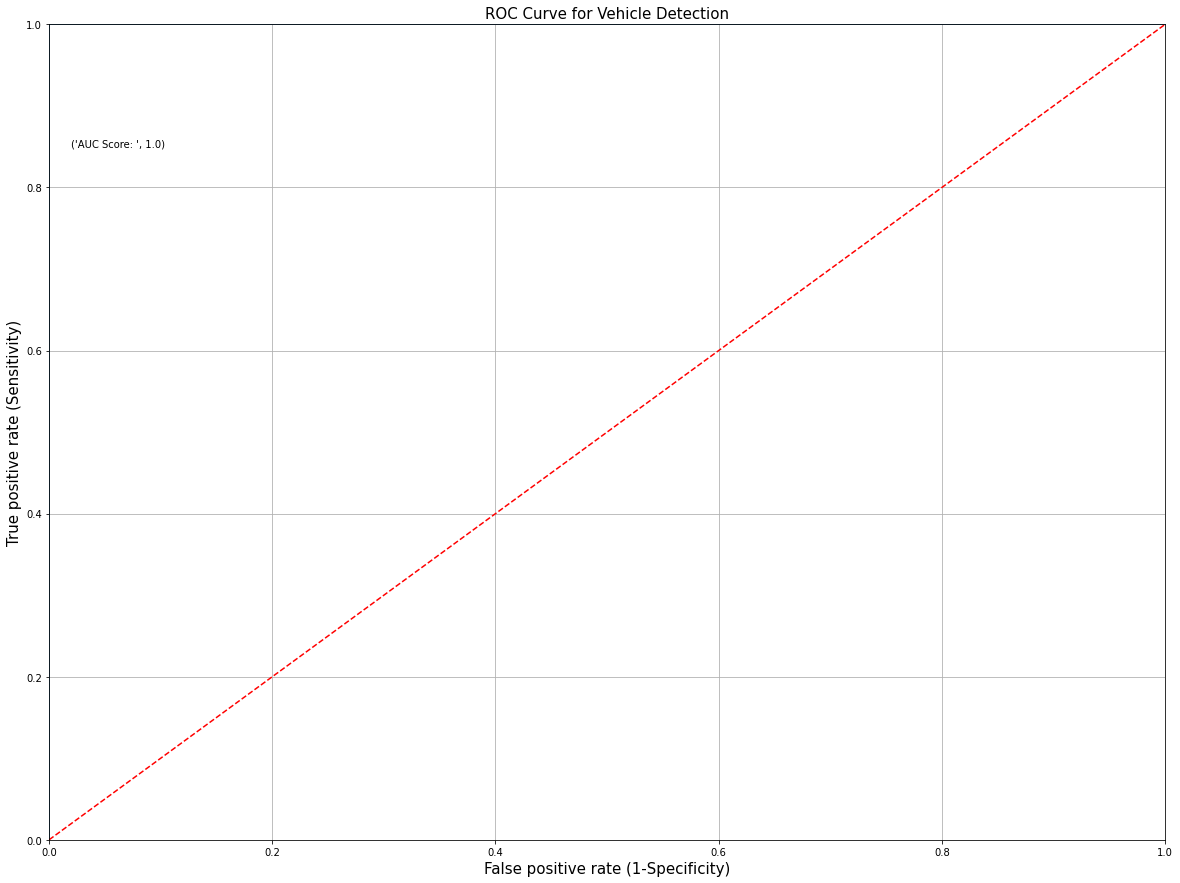

In [42]:
plot_roc(y_pred_prob)

In [44]:
y_pred = [1 if i>0.5 else 0 for i in y_pred_prob] 

Cohen Kappa Score: 1.0 

Classification Report--> 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



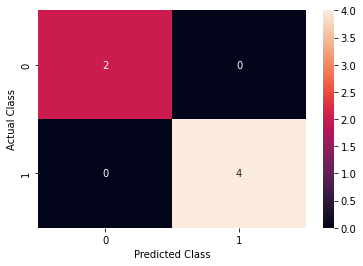

In [45]:
model_evaluation(y_test, y_pred)

##Model Deployment

In [ ]:
!pip install gradio

In [48]:
import gradio as gr
def predict_image(image):
    data_pred  = []
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data_pred.append(image)
    d = np.array(data_pred, dtype = "float")
    preds = best_model.predict(d)
    if preds<0.5:
        prediction = "No Potholes"
    else:
        prediction = "Pothole"
    
    return prediction

im = gr.inputs.Image(shape=(28,28))
label = gr.outputs.Label()

gr.Interface(fn=predict_image, inputs=im, outputs=label, capture_session=True, title="Pothole Detection").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://57461.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fd7d441e450>,
 'http://127.0.0.1:7861/',
 'https://57461.gradio.app')